In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import speculator
from speculator import  Photulator
import fsps
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
filter_list = fsps.find_filter('lsst') + fsps.find_filter('suprimecam')[1:2]+fsps.find_filter('suprimecam')[3:]
filter_list

['lsst_u',
 'lsst_g',
 'lsst_r',
 'lsst_i',
 'lsst_z',
 'lsst_y',
 'suprimecam_g',
 'suprimecam_r',
 'suprimecam_i',
 'suprimecam_z']

In [4]:
spsparams = np.load("data/data/training_params.npy")[:1000000]
photometry = np.load("data/data/training_data.npy")[:1000000]
print(spsparams.shape, photometry.shape)

(1000000, 15) (1000000, 10)


In [5]:
# parameters shift and scale
parameters_shift = np.mean(spsparams, axis=0)
parameters_scale = np.std(spsparams, axis=0)
magnitudes_shift = np.mean(photometry, axis=0)
magnitudes_scale = np.std(photometry, axis=0)

In [6]:
device='mps'
training_theta = torch.from_numpy(spsparams).float().to(device)
training_mags = torch.from_numpy(photometry[:,0]).float().to(device)

In [7]:
n_parameters = spsparams.shape[-1]
n_layers=4
n_units=128
n_hidden = [n_units]*n_layers

In [8]:
#model for lsst u
photulator = Photulator(n_parameters=n_parameters,
                           filters=[filter_list[0]],
                           parameters_shift=parameters_shift,
                           parameters_scale=parameters_scale,
                           magnitudes_shift=magnitudes_shift[0],
                           magnitudes_scale=magnitudes_scale[0],
                           n_hidden=n_hidden,
                           optimizer=lambda x: torch.optim.Adam(x, lr=1e-3),
                           device=device)

photulator.set_device(device)

In [9]:
#create dataset
training_dataset = torch.utils.data.TensorDataset(training_theta, training_mags)
training_data, validation_data = torch.utils.data.random_split(training_dataset, [0.90, 0.1])
validation_theta, validation_mag = validation_data[:]

trainloader = torch.utils.data.DataLoader(training_data, batch_size=1000,
                                          shuffle=True)



In [10]:
j = 0
loss_list = []
validation_loss = []
#loop over dataset multiple times
for epoch in range(2):
    print("epoch ", j)
    #loops over batches
    i = 0
    for th, mgs in trainloader:

        # zero the parameter gradients
        photulator.optimizer.zero_grad()

        th.to(device)
        mgs.to(device)

        loss = photulator.compute_loss(th, mgs)
        loss.backward()
        photulator.optimizer.step()
        
        loss_list.append(loss.item())

        if(i%100 == 0):
            print(i)
        i+=1
    
    validation_loss.append(photulator.compute_loss(validation_theta, torch.reshape(validation_mag, (validation_mag.shape[0], 1))).item())
    j+=1

epoch  0
0
100
200


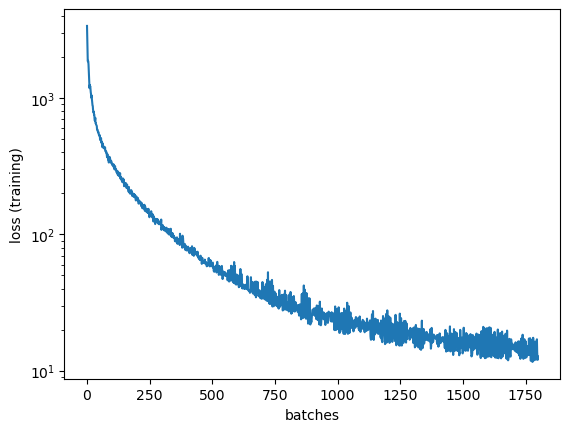

In [ ]:
plt.plot(loss_list)
plt.ylabel('loss (training)')
plt.xlabel('batches')
plt.yscale("log")

Text(0.5, 0, 'epoch')

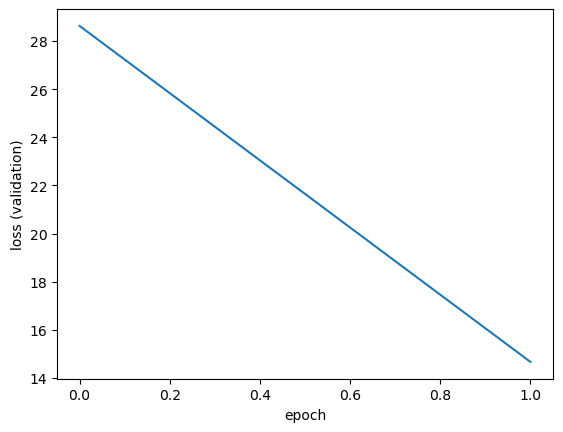

In [ ]:
plt.plot(validation_loss)
plt.ylabel('loss (validation)')
plt.xlabel('epoch')